### Chaning VGG net to make autencoder, by removing last few layers and adding the image respective layers at the end.  
Using only one directory to train the model and testing on different dataset.

### Task:
1. The test task requires a pre-trained VGG16 model as well as the Tiny ImageNet database. You can access the former via torchvision (the task should generally be erformed in pytorch).
2. Crop off the last layers from the model (fully connected, ReLu, Softmax). Add a small network at the end of the cropped model that is able to output a 50 by 50 image given the output of the cropped model. Further adapt the model to use the samples from the Tiny ImageNet database as input.
3. Train the (approximated) identity function only on the part you added (on the Tiny ImageNet samples), finetuning the necessary training parameters. Use the n07768694 samples for training only.
4. Afterwards, plot the first 10 pairs of input/output samples from the training set as well as from the test set respectively. Add some comments on the problems you encountered.

In [ ]:
import torch,os, time,copy
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.utils.data as data
from torch.autograd import Variable
import numpy as np
import torchvision
import torch.nn.functional as F
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

In [109]:
data_dir_train = 'tiny-imagenet-200/train/n07768694'
data_dir_test = 'tiny-imagenet-200'

# convert data to torch.FloatTensor
#transform = transforms.Compose([transforms.Resize(224),transforms.ToTensor()])

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
    ])
}
image_datasets_train = {x: datasets.ImageFolder(os.path.join(data_dir_train, x), data_transforms[x]) 
                  for x in ['train']}

image_datasets_test = {x: datasets.ImageFolder(os.path.join(data_dir_test, x), data_transforms[x]) 
                  for x in ['test']}


print(image_datasets_train)
print(image_datasets_test)

{'train': Dataset ImageFolder
    Number of datapoints: 500
    Root location: tiny-imagenet-200/train/n07768694\train
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )}
{'test': Dataset ImageFolder
    Number of datapoints: 10000
    Root location: tiny-imagenet-200\test
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )}


In [113]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

# prepare data loaders
train_loader = torch.utils.data.DataLoader(image_datasets_train, batch_size=100, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(image_datasets_test, batch_size=100, num_workers=num_workers)

print(train_loader)

In [114]:
model_vgg16 = models.vgg16_bn(True)

# Freeze training for all layers
for param in model_vgg16.features.parameters():
    param.require_grad = False

# Newly created modules have require_grad=True by default
num_features = model_vgg16.classifier[0].in_features

#Removing last few layers
features = list(model_vgg16.classifier.children())[:-8]
features.extend([nn.Linear(num_features, 7500)]) # Add our layer with 2500 ouput - 50 *50 
model_vgg16.classifier = nn.Sequential(*features) # Replace the model classifier
#print(model_vgg16)

In [115]:
optimizer = torch.optim.Adam(model_vgg16.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [ ]:
# number of epochs to train the model
n_epochs = 10
trainh_loss=[]
testh_loss=[]


model_vgg16.train(True)   

for epoch in range(1, n_epochs+1):
    train_loss = 0.0
    test_loss = 0.0
    ## Training and Checking error in train set.
    for i,data in enumerate(train_loader):
        # _ stands in for labels, here
        inputs, labels = data
        inputs, labels = Variable(inputs), Variable(labels)
        
#        images, _ = data
        # flatten images
#        images = images.view(images.size(0), -1)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        inputs1 = F.interpolate(inputs, size=(50,50))
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model_vgg16(inputs)
        outputs = outputs.reshape(10,3,50,50)
        # calculate the loss
        loss = criterion(outputs, inputs1)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()
        
            # Average training score
    train_loss = train_loss/len(train_loader)
    
    trainh_loss.append(train_loss) 
    
    print('Epoch: {} \tTraining Loss: {:.6f} \t Test Loss: {:.6f}'.format(
        epoch, 
        train_loss,
        test_loss
        ))

Original Images


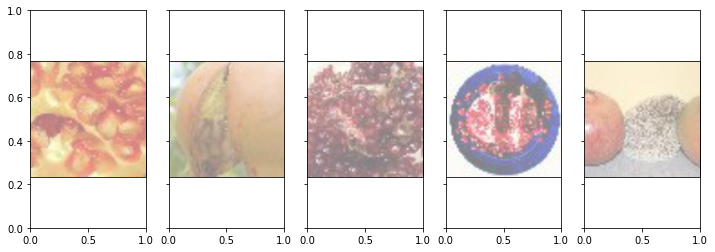

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Reconstructed Images


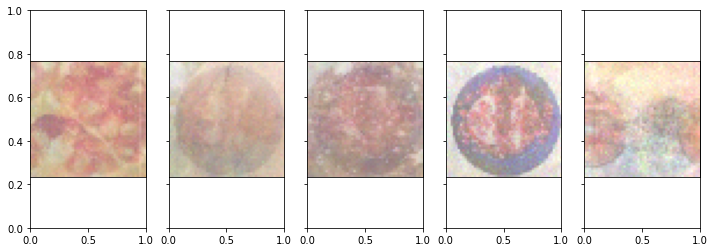

In [92]:
#Batch of test images
dataiter = iter(dataloaders['test'])
images, labels = dataiter.next()

#Sample outputs
output = model_vgg16(images)
images = images.numpy()

output = output.view(10, 3, 50, 50)
output = output.detach().numpy()

#Original Images
print("Original Images")
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
plt.show()

#Reconstructed Images
print('Reconstructed Images')
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(output[idx])
plt.show() 